In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import hashlib
import glob
import os
import pbn_37k.img as iImg
from pbn_37k.ask import sigAssistant
from pbn_37k.dbkg import consolidateBits



In [4]:
import pandas as pd
import numpy as np
import json
import glob, os
import hashlib
import datetime
from openpyxl import load_workbook
from openpyxl.styles import Alignment
from pbn_37k.hlp import getXY
from datetime import datetime
from importlib import resources
path_to_defs = resources.files("pbn_37k.data.definitions").joinpath("content.md")
def integrateReview(path):
    if "ctivit" in path:
        typeReview = "Activities"
    elif "ision" in path:
        typeReview = "Vision"
    else:
        typeReview = "ToBeConfirmed"
    wb = load_workbook(path)
    #print(wb.sheetnames)

    reviews = [x for x in wb.sheetnames if ((x not in ['Cover', 'HowTo', 'Definitions']) and (len(x) == 12))]
    if len(reviews) == 0:
        reviews = [x for x in wb.sheetnames if (x not in ['Cover', 'HowTo', 'Definitions'])]
    X, Y, terms = getXY(PATH=path_to_defs)
    inv_terms = {v: k for k, v in terms.items()}

    REVIEWS = []

    FromProbono = True
    #print(reviews)
    for R in reviews:

        ws = wb[R]
        activity = ws["C4"].value
        title = ws["C5"].value
        rev = ws["C8"].value
        origin = ws["C6"].value
        Place = ws["L6"].value
        reviewBy = ws["C7"].value
        reviewDate = ws["L7"].value

        # Parsing the table of scoring
        i = 11
        SCORES = []
        DONE = False
        #print(R)
        while not DONE:
            if not ws["C"+str(i)].value:
                DONE = True
                break
            purp = ws["C"+str(i)].value
            iss = ws["D"+str(i)].value
            purp = purp.replace("A","A.")
            iss = iss.replace("B","B.")
            scoreB = ws["E"+str(i)].value
            scoreN = ws["F"+str(i)].value
            justif = ws["G"+str(i)].value

            if scoreB:
                A = [FromProbono, origin, Place, typeReview, rev, justif, purp, iss, 'Building', scoreB, '',title, True,reviewBy,reviewDate]
                REVIEWS.append(A)
            if scoreN:
                A = [FromProbono, origin, Place, typeReview, rev, justif, purp, iss, 'Neighbourhood', scoreN, '',title, True,reviewBy,reviewDate]
                REVIEWS.append(A)
            i += 1
        #print("Processing reviewed data from",path,i,typeReview)
        pdr = pd.DataFrame(REVIEWS,columns=['FromProbono', 'Origin', 'Place', 'Type', 'Source', 'Justification', 'Purpose', 'Issue', 'Scale', 'Score', 'Justification_Short', 'Source_Title', 'Reviewed',"reviewBy","reviewDate"])
        pdr["pathFile"] = path
        pdr.Purpose =pdr.Purpose.apply(lambda x: terms[x])
        pdr.Issue = pdr.Issue.apply(lambda x: terms[x])
        sign = "* "+"\n* ".join(list(pdr.Source))
        sign = str(hashlib.md5(sign.encode("utf-8")).hexdigest())
        pdr['timestamp']= datetime.now().strftime('%Y-%m-%d %X')
        #pdr.to_excel("data/xls/"+sign+".xlsx")
    return pdr

# Certifications

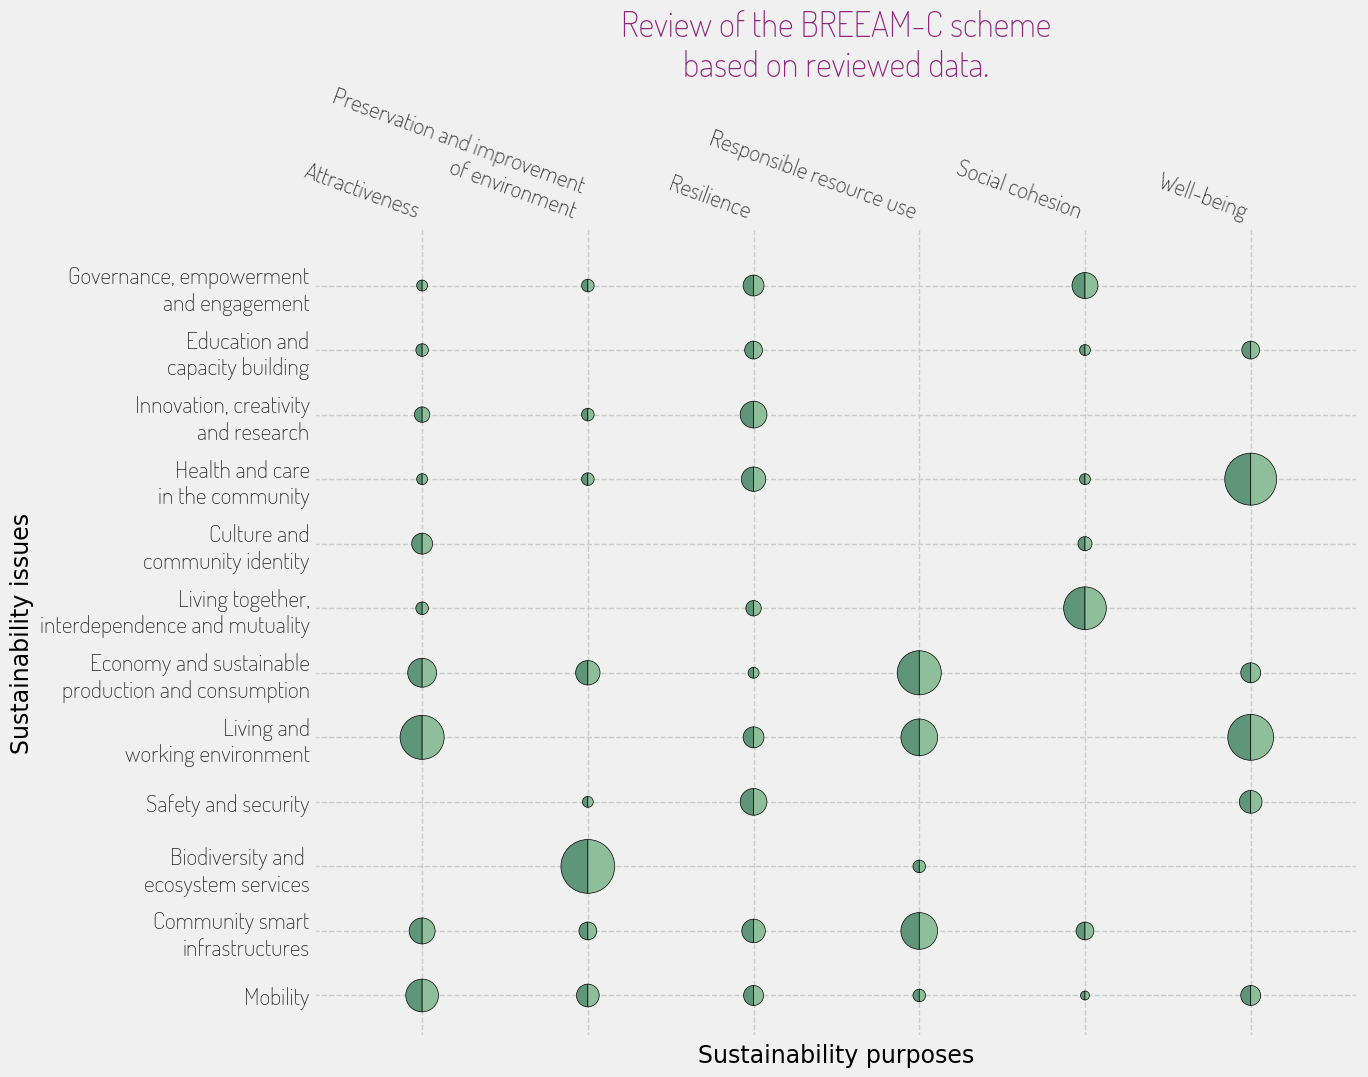

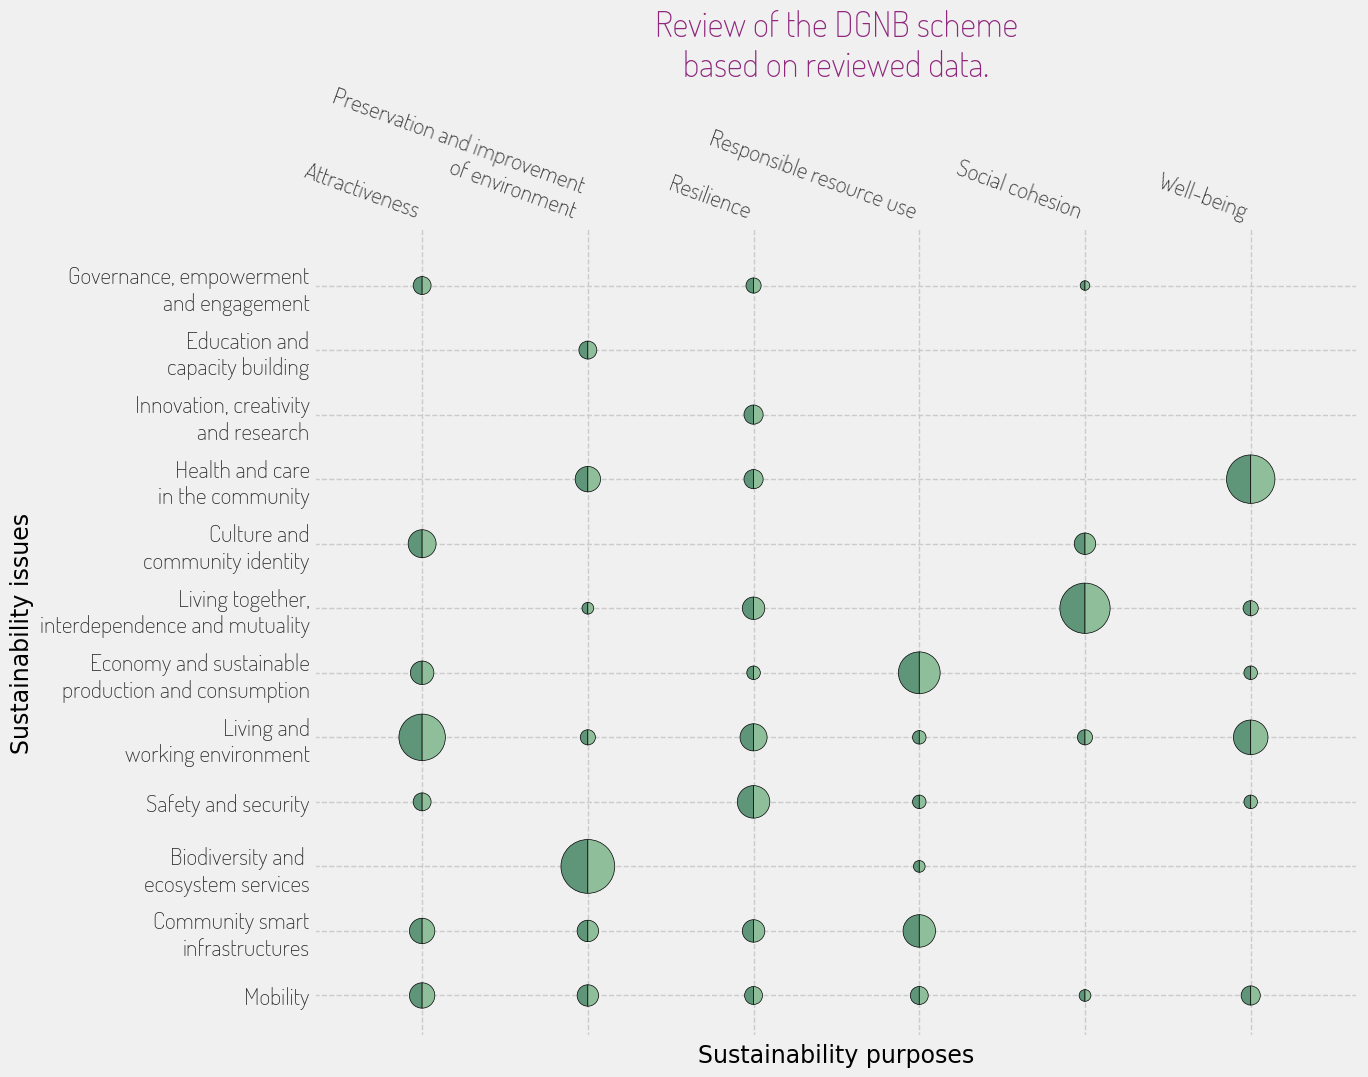

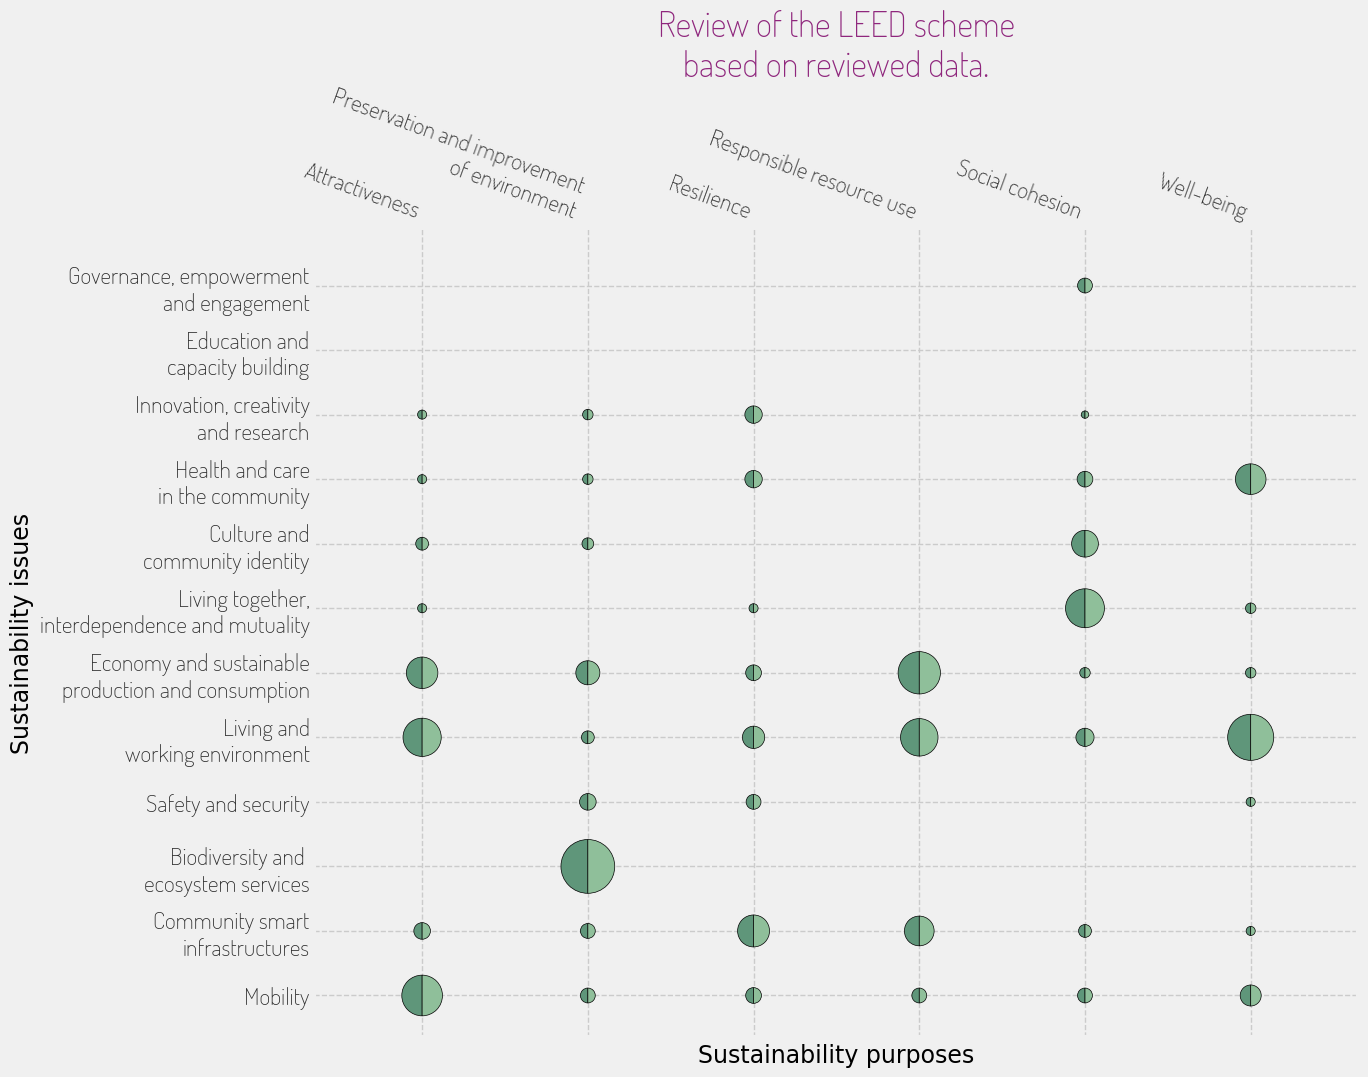

In [5]:
certifs = ["BREEAM-C", "DGNB", "LEED"]

for cert in certifs:
    A = integrateReview("data/in/certs/certif_"+cert+".xlsx")
    A = A.sort_values("Score", ascending=False)
    A = A.drop_duplicates(subset=['Source', 'Purpose', 'Issue'], keep='first')
    A["Scale"] = "Neighbourhood"
    B = A.copy()
    B["Scale"] = "Building"
    A = pd.concat([A,B], ignore_index=True)
    plt, ax = iImg.createImg(A,A[A.Score == 0],title="Review of the "+cert+" scheme\nbased on reviewed data.")
    ax.set_xlabel("Sustainability purposes")
    ax.set_ylabel("Sustainability issues")
    ax.legend().set_visible(False)
    plt.savefig("data/out/certs/iso37101_map_"+cert+".png", bbox_inches='tight')

# Living Labs


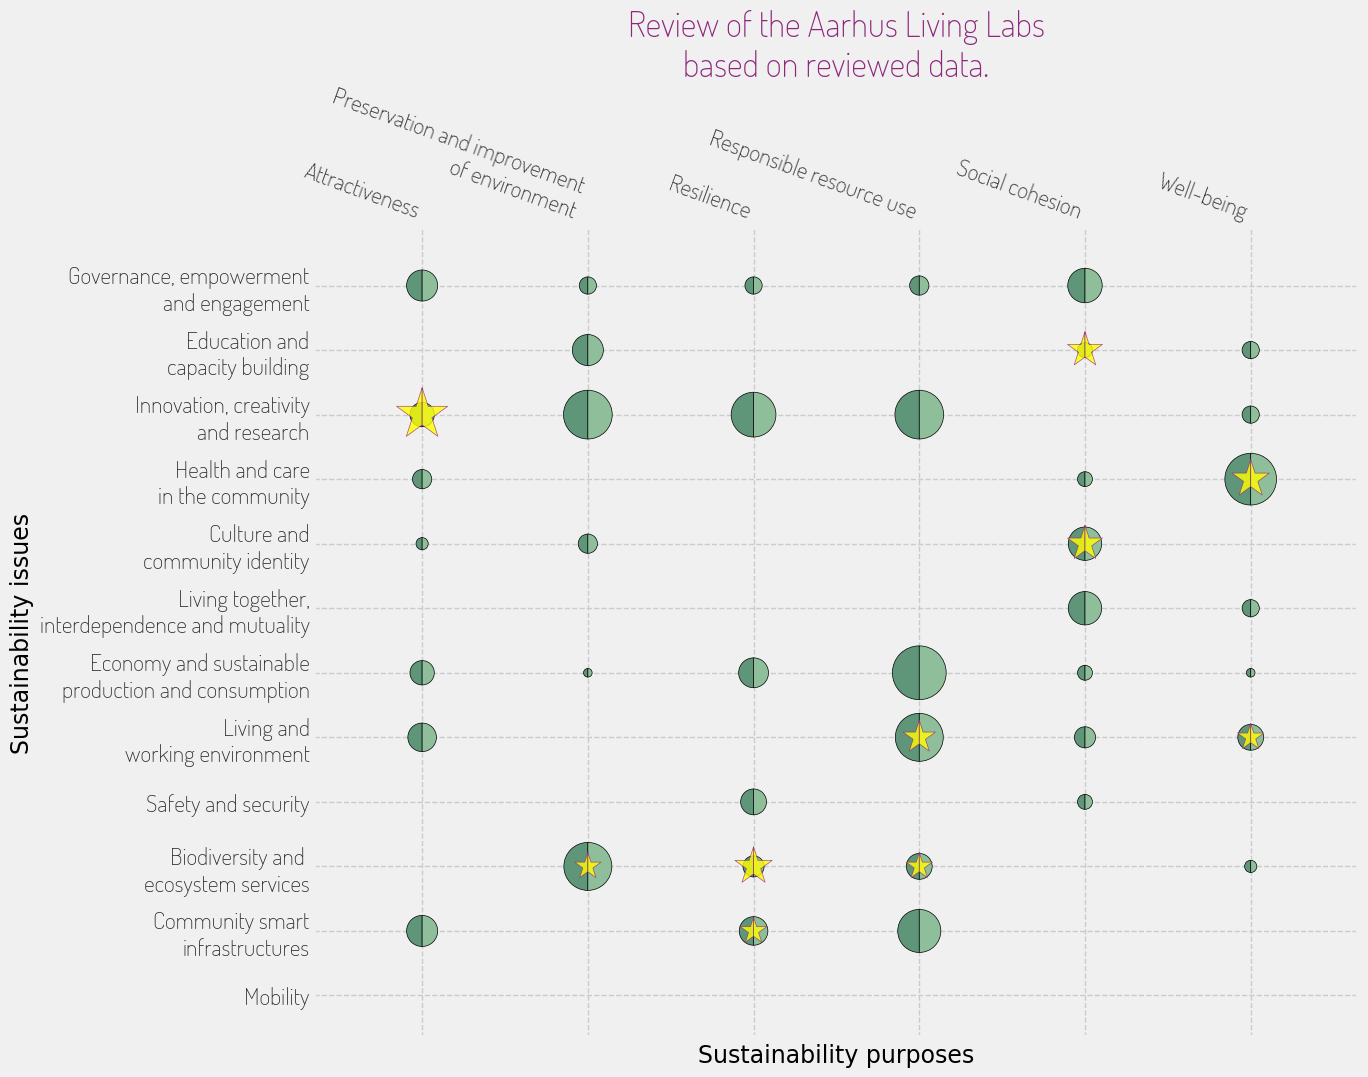

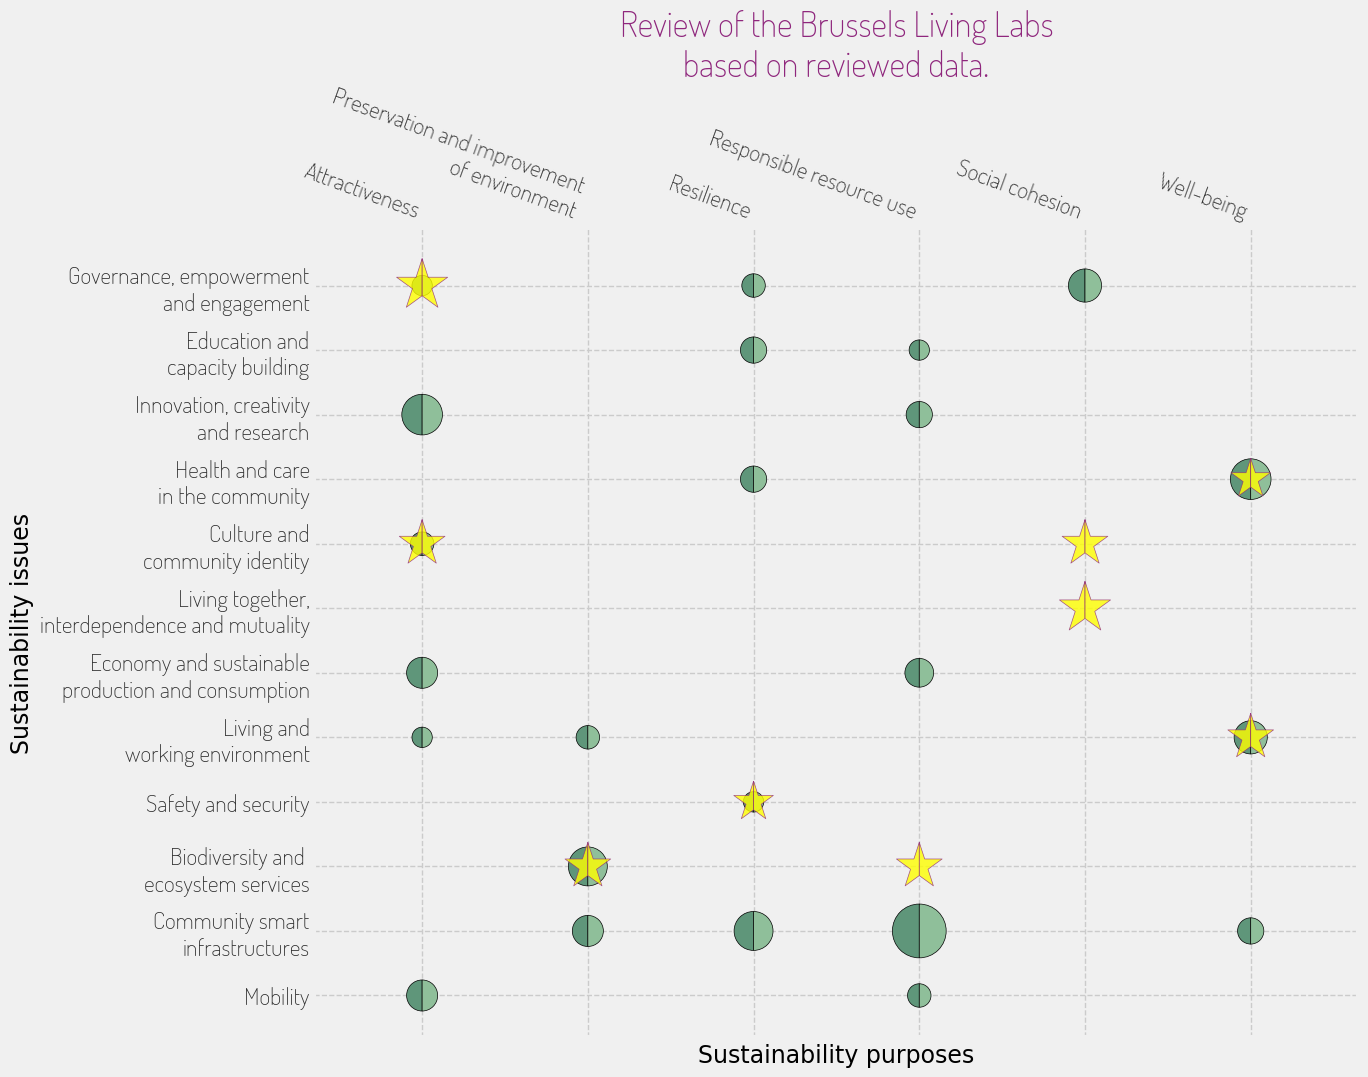

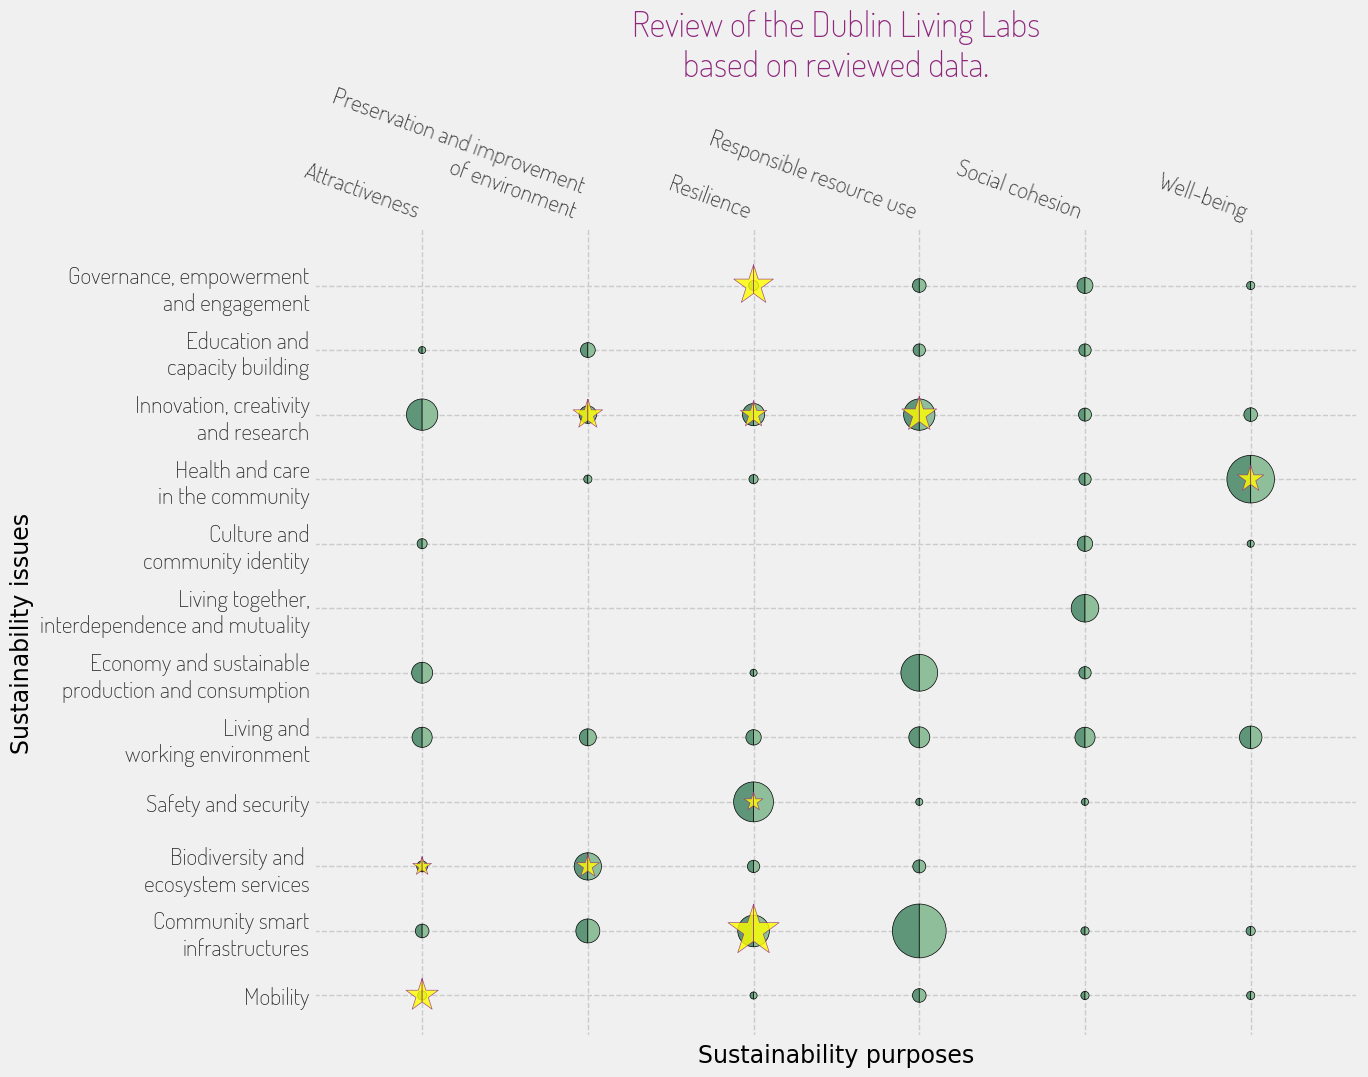

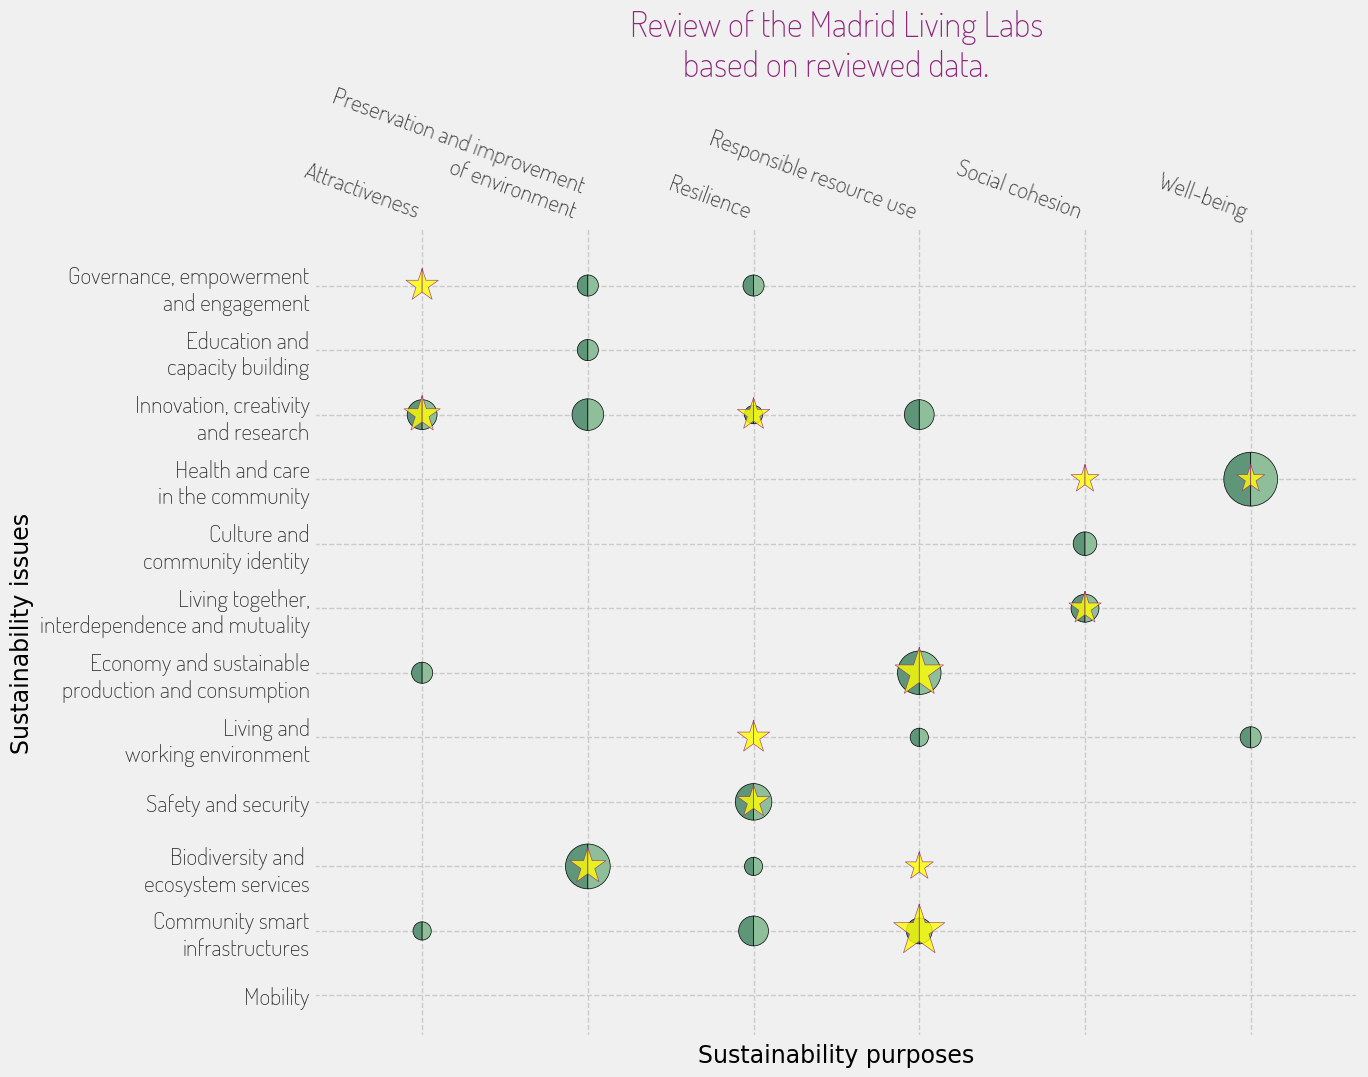

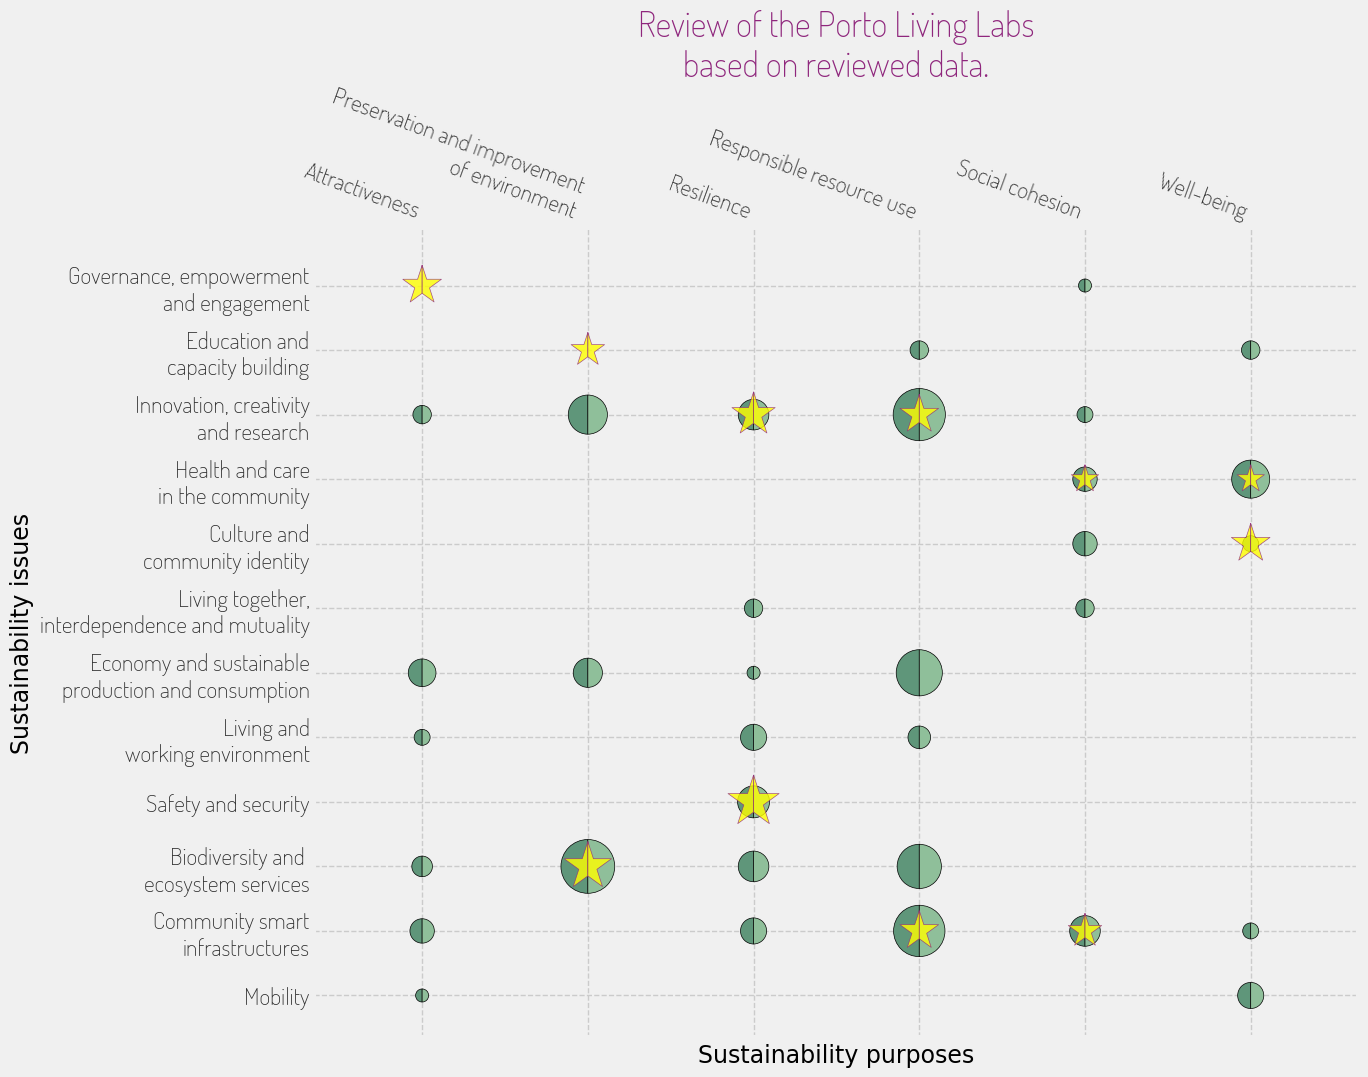

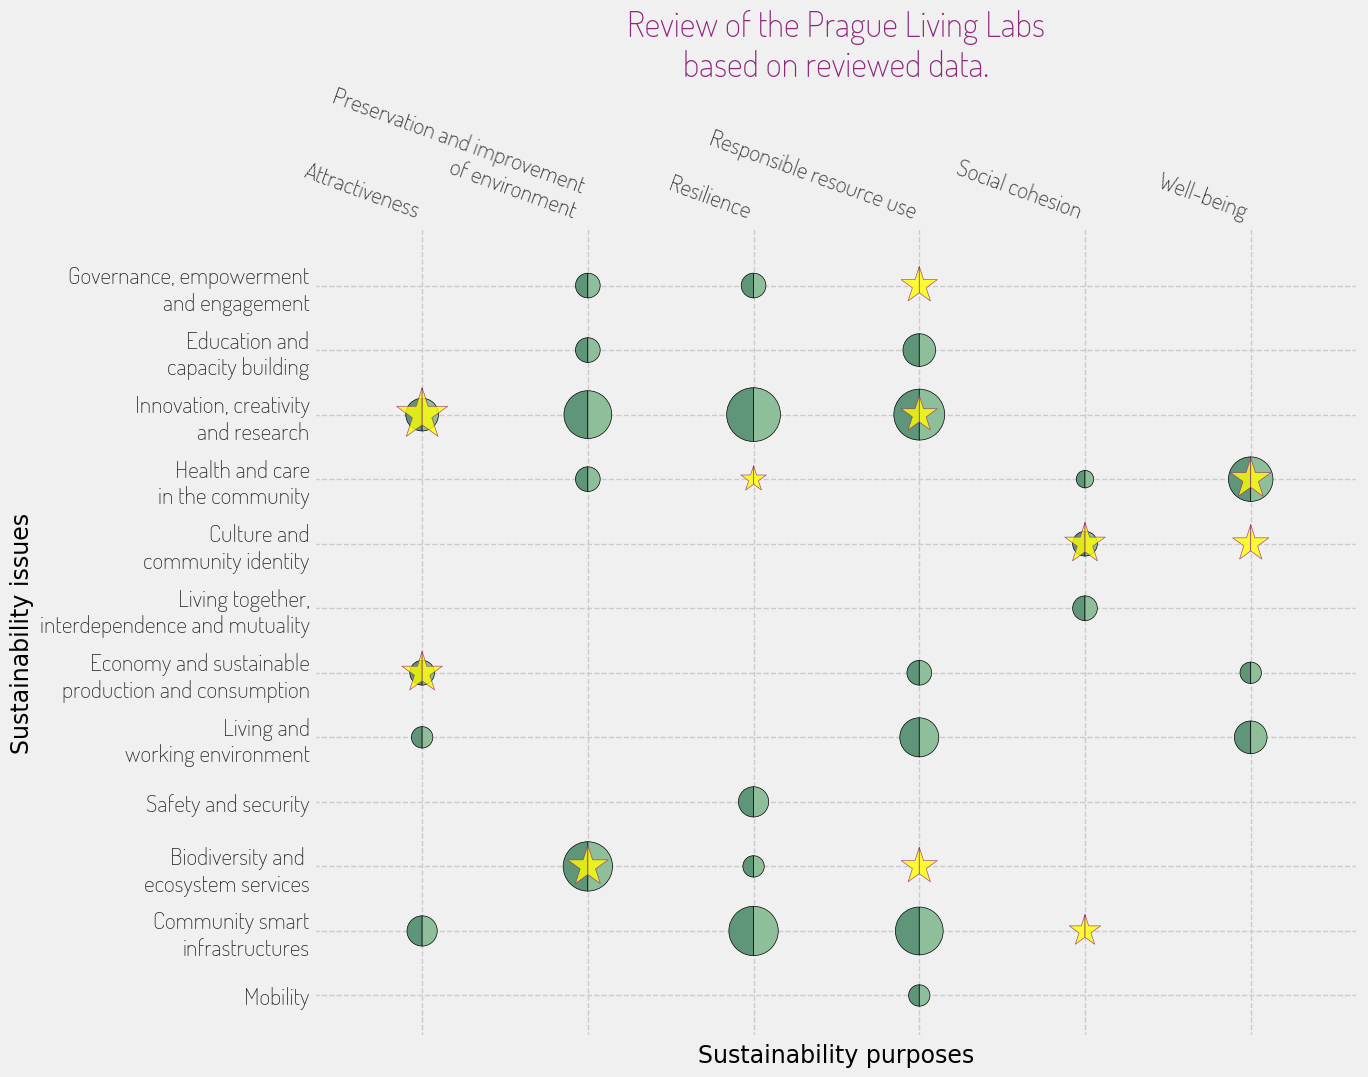

In [8]:
lls = ["Aarhus","Brussels","Dublin","Madrid","Porto","Prague"]

for ll in lls:
    
    for typeReview in ["Activities","Vision"]:
        reviews = []
        A = integrateReview("data/in/lls/iso37101_"+typeReview+"_"+ll+".xlsx")
        A = A.sort_values("Score", ascending=False)
        A = A.drop_duplicates(subset=['Source', 'Purpose', 'Issue'], keep='first')
        A["Scale"] = "Neighbourhood"
        reviews.append(A)
        B = A.copy()
        B["Scale"] = "Building"
        reviews.append(B)
        if typeReview == "Activities":
            circles = pd.concat(reviews, ignore_index=True)
        else:
            stars = pd.concat(reviews, ignore_index=True)

    plt, ax = iImg.createImg(circles,stars,title="Review of the "+ll+" Living Labs\nbased on reviewed data.")
    ax.set_xlabel("Sustainability purposes")
    ax.set_ylabel("Sustainability issues")
    ax.legend().set_visible(False)
    plt.savefig("data/out/lls/iso37101_map_"+ll+".png", bbox_inches='tight')